## Calculating NDVI for our Area of Interest

### Loading the necessary libraries

In [2]:
import rasterio
import numpy
import matplotlib.pyplot as plt

In [ ]:
### Extracting the data from the red and near-infrared bands


In [19]:
filename = 'image.tif'
with rasterio.open(filename) as src:
    band_red = src.read(3)
with rasterio.open(filename) as src:
    band_nir = src.read(4)


In [ ]:
## Calculating NDVI

In [20]:
# Do not display error when divided by zero 

numpy.seterr(divide='ignore', invalid='ignore')

# NDVI 
ndvi = (band_nir.astype(float) - band_red.astype(float)) / (band_nir + band_red)



-0.5822594671515535
0.5731284302963776


### Checking the range of NDVI values(excluding NaN)
Let's print the minimum and maximum values in our calculated ndvi. Because we're using the NDVI formula to normalize the input bands, we know that our expected values should fall within -1.0 to +1.0.

In [ ]:
print(numpy.nanmin(ndvi)) 
print(numpy.nanmax(ndvi))

## Saving the NDVI image

We will save the results to a new single band image. This new image file will use the geospatial data rom the original geotiff image.

In [21]:
# get the metadata of original GeoTIFF:
meta = src.meta
print(meta)

# get the dtype of our NDVI array:
ndvi_dtype = ndvi.dtype
print(ndvi_dtype)

# set the source metadata as kwargs we'll use to write the new data:
kwargs = meta

# update the 'dtype' value to match our NDVI array's dtype:
kwargs.update(dtype=ndvi_dtype)

# update the 'count' value since our output will no longer be a 4-band image:
kwargs.update(count=1)

# Finally, use rasterio to write new raster file 'data/ndvi.tif':
with rasterio.open('ndvi.tif', 'w', **kwargs) as dst:
        dst.write(ndvi, 1)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 6449, 'height': 5802, 'count': 4, 'crs': CRS({'init': 'epsg:32644'}), 'transform': Affine(3.0, 0.0, 505761.0,
       0.0, -3.0, 2180130.0)}
float64


### Applying a color scheme to visualize the NDVI values on the new image
The values in our NDVI will range from -1 to 1. To best visualize this, we want to use a diverging color scheme, and we want to center the colorbar at a defined midpoint.



In [22]:
from matplotlib import colors


class MidpointNormalize(colors.Normalize):
   
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
       
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return numpy.ma.masked_array(numpy.interp(value, x, y), numpy.isnan(value))

### Interpretation of NDVI

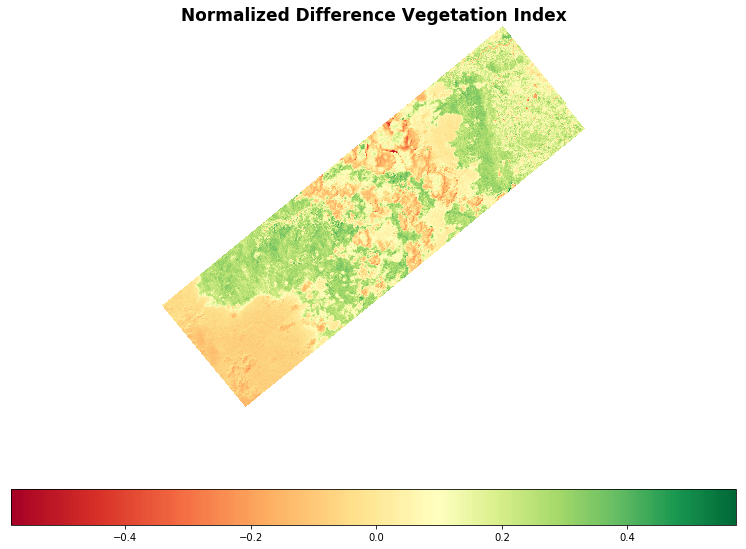

In [23]:

# Set min/max values from NDVI range for image

min=numpy.nanmin(ndvi)
max=numpy.nanmax(ndvi)

# Set our custom midpoint for most effective NDVI analysis
mid=0.1

# Setting color scheme ref:https://matplotlib.org/users/colormaps.html as a reference
colormap = plt.cm.RdYlGn 
norm = MidpointNormalize(vmin=min, vmax=max, midpoint=mid)
fig = plt.figure(figsize=(20,10))


ax = fig.add_subplot(111)

# Use 'imshow' to specify the input data, colormap, min, max, and norm for the colorbar
cbar_plot = ax.imshow(ndvi, cmap=colormap, vmin=min, vmax=max, norm=norm)


# Turn off the display of axis labels 
ax.axis('off')

# Set a title 
ax.set_title('Normalized Difference Vegetation Index', fontsize=17, fontweight='bold')

# Configure the colorbar
cbar = fig.colorbar(cbar_plot, orientation='horizontal', shrink=0.65)

# Call 'savefig' to save this plot to an image file
fig.savefig("ndvi-image.png", dpi=200, bbox_inches='tight', pad_inches=0.7)

# let's visualize
plt.show()

## Generating a histogram of NDVI values

A Histogram or any other chart  can be useful for quick analysis by giving a visual insight into the distribution of "healthy" vs "unhealthy" vegetation values in your study area.

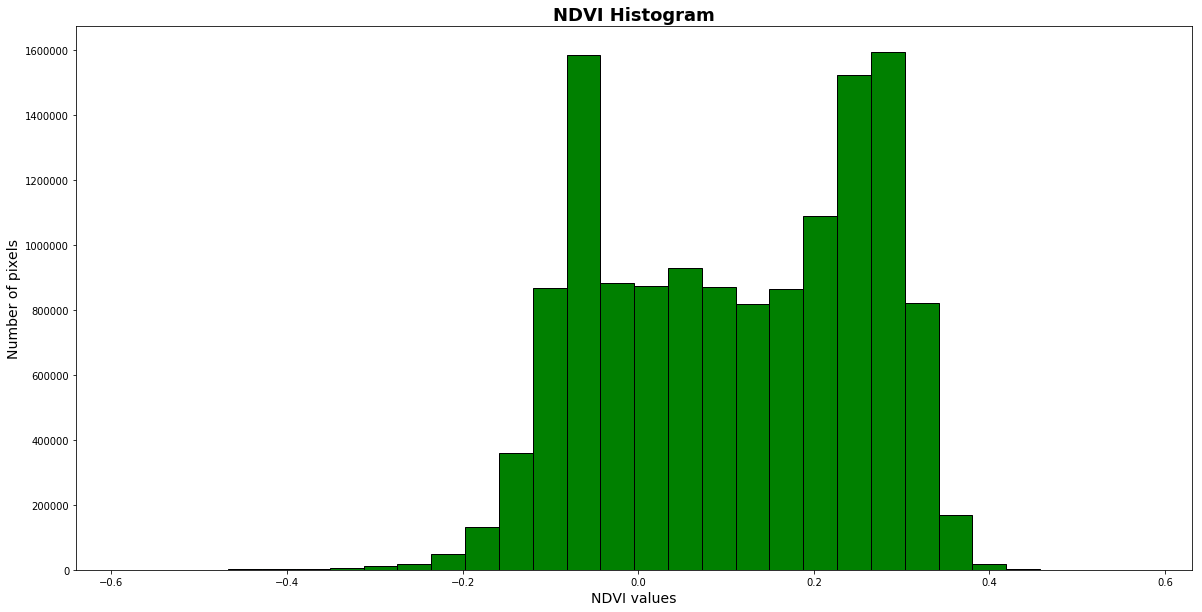

In [24]:
# Define a new figure
fig2 = plt.figure(figsize=(20,10))

# Give this new figure a subplot, which will contain the histogram itself
ax = fig2.add_subplot(111)

# Add a title & (x,y) labels to the plot
plt.title("NDVI Histogram", fontsize=18, fontweight='bold')
plt.xlabel("NDVI values", fontsize=14)
plt.ylabel("Number of pixels", fontsize=14)


# For the x-axis, we want to count every pixel that is not an empty value
x = ndvi[~numpy.isnan(ndvi)]
color = 'g'
# call 'hist` with our x-axis, bins, and color details
ax.hist(x,bins=30,color=color,histtype='bar', ec='black')

# Save the generated figure to an external image file
#fig2.savefig("ndvi-histogram.png", dpi=200, bbox_inches='tight', pad_inches=0.5)


plt.show()